In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

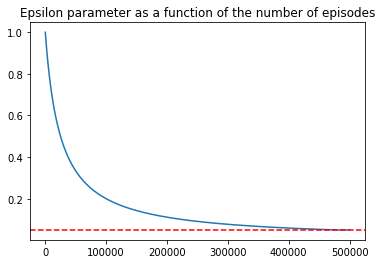

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 217
add_noise = False

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

#     else:
#         raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


#     ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

#     # Output headers to file
#     with open(rewards_file,'w') as f:
#          np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.08  minuts. epsilon 0.9961 Discounted reward:  -19.14651274759525
Episode: 200. Elapsed time  0.18  minuts. epsilon 0.9921 Discounted reward:  -18.20129544193786
Episode: 300. Elapsed time  0.3  minuts. epsilon 0.9882 Discounted reward:  -18.12220165222712
Episode: 400. Elapsed time  0.44  minuts. epsilon 0.9843 Discounted reward:  -15.961819783369851
Episode: 500. Elapsed time  0.59  minuts. epsilon 0.9804 Discounted reward:  -21.236014928692178
Episode: 600. Elapsed time  0.76  minuts. epsilon 0.9766 Discounted reward:  -19.97428704579241
Episode: 700. Elapsed time  0.93  minuts. epsilon 0.9728 Discounted reward:  -22.442674846423518
Episode: 800. Elapsed time  1.12  minuts. epsilon 0.969 Discounted reward:  -20.819016227771755
Episode: 900. Elapsed time  1.33  minuts. epsilon 0.9653 Discounted reward:  -15.492851775525835
Episode: 1000. Elapsed time  1.56  minuts. epsilon 0.9616 Discounted reward:  -20.715333227466793
Episode: 1100. Elapsed time  1.77  

Episode: 8500. Elapsed time  34.63  minuts. epsilon 0.7463 Discounted reward:  -18.145641635487937
Episode: 8600. Elapsed time  35.2  minuts. epsilon 0.7441 Discounted reward:  -8.17605932803481
Episode: 8700. Elapsed time  35.78  minuts. epsilon 0.7419 Discounted reward:  -10.063183241534606
Episode: 8800. Elapsed time  36.36  minuts. epsilon 0.7397 Discounted reward:  -14.4830714206749
Episode: 8900. Elapsed time  36.95  minuts. epsilon 0.7375 Discounted reward:  -10.754588814292578
Episode: 9000. Elapsed time  37.55  minuts. epsilon 0.7353 Discounted reward:  -22.054460051977777
Episode: 9100. Elapsed time  38.14  minuts. epsilon 0.7332 Discounted reward:  -11.842809350612239
Episode: 9200. Elapsed time  38.72  minuts. epsilon 0.731 Discounted reward:  -18.626244283208276
Episode: 9300. Elapsed time  39.32  minuts. epsilon 0.7289 Discounted reward:  -13.386330062050687
Episode: 9400. Elapsed time  39.92  minuts. epsilon 0.7268 Discounted reward:  -8.005308926789137
Episode: 9500. El

Episode: 16800. Elapsed time  90.16  minuts. epsilon 0.5981 Discounted reward:  -7.212735182885756
Episode: 16900. Elapsed time  91.0  minuts. epsilon 0.5967 Discounted reward:  -6.577215228652042
Episode: 17000. Elapsed time  91.72  minuts. epsilon 0.5953 Discounted reward:  -15.74646732739561
Episode: 17100. Elapsed time  92.46  minuts. epsilon 0.5938 Discounted reward:  -10.426772918512103
Episode: 17200. Elapsed time  93.2  minuts. epsilon 0.5924 Discounted reward:  -9.654750437411781
Episode: 17300. Elapsed time  93.94  minuts. epsilon 0.591 Discounted reward:  -6.7799941525258625
Episode: 17400. Elapsed time  94.69  minuts. epsilon 0.5896 Discounted reward:  -10.83612680089327
Episode: 17500. Elapsed time  95.43  minuts. epsilon 0.5882 Discounted reward:  -10.208274535897484
Episode: 17600. Elapsed time  96.18  minuts. epsilon 0.5869 Discounted reward:  -5.1838570420017565
Episode: 17700. Elapsed time  96.94  minuts. epsilon 0.5855 Discounted reward:  -13.392191515135035
Episode:

Episode: 25100. Elapsed time  155.64  minuts. epsilon 0.499 Discounted reward:  -10.197366186221062
Episode: 25200. Elapsed time  156.44  minuts. epsilon 0.498 Discounted reward:  -10.108798063834849
Episode: 25300. Elapsed time  157.26  minuts. epsilon 0.497 Discounted reward:  -8.05130864494024
Episode: 25400. Elapsed time  158.06  minuts. epsilon 0.496 Discounted reward:  -4.3542794928463024
Episode: 25500. Elapsed time  158.89  minuts. epsilon 0.4951 Discounted reward:  -10.726894353904832
Episode: 25600. Elapsed time  159.72  minuts. epsilon 0.4941 Discounted reward:  -9.877012723331257
Episode: 25700. Elapsed time  160.57  minuts. epsilon 0.4931 Discounted reward:  -3.935793858876143
Episode: 25800. Elapsed time  161.4  minuts. epsilon 0.4921 Discounted reward:  -10.060357408047595
Episode: 25900. Elapsed time  162.24  minuts. epsilon 0.4912 Discounted reward:  -6.155196192490532
Episode: 26000. Elapsed time  163.04  minuts. epsilon 0.4902 Discounted reward:  -9.780282348578313
E

Episode: 33300. Elapsed time  225.86  minuts. epsilon 0.4288 Discounted reward:  -4.153143880280621
Episode: 33400. Elapsed time  226.75  minuts. epsilon 0.4281 Discounted reward:  -6.357247305863278
Episode: 33500. Elapsed time  227.64  minuts. epsilon 0.4274 Discounted reward:  -9.996277254377175
Episode: 33600. Elapsed time  228.52  minuts. epsilon 0.4266 Discounted reward:  -11.550811682016697
Episode: 33700. Elapsed time  229.39  minuts. epsilon 0.4259 Discounted reward:  -6.6035481460887295
Episode: 33800. Elapsed time  230.28  minuts. epsilon 0.4252 Discounted reward:  -8.640597542614932
Episode: 33900. Elapsed time  231.17  minuts. epsilon 0.4245 Discounted reward:  -9.283054035616797
Episode: 34000. Elapsed time  232.05  minuts. epsilon 0.4237 Discounted reward:  -8.810660496225447
Episode: 34100. Elapsed time  232.93  minuts. epsilon 0.423 Discounted reward:  -9.19058189657539
Episode: 34200. Elapsed time  233.83  minuts. epsilon 0.4223 Discounted reward:  -4.75182393938942
E

Episode: 41500. Elapsed time  300.03  minuts. epsilon 0.3759 Discounted reward:  -1.685473687659328
Episode: 41600. Elapsed time  300.95  minuts. epsilon 0.3754 Discounted reward:  -5.8595978877687545
Episode: 41700. Elapsed time  301.86  minuts. epsilon 0.3748 Discounted reward:  -5.832035969206765
Episode: 41800. Elapsed time  302.78  minuts. epsilon 0.3743 Discounted reward:  -5.289862210262915
Episode: 41900. Elapsed time  303.7  minuts. epsilon 0.3737 Discounted reward:  -4.203869864890716
Episode: 42000. Elapsed time  304.61  minuts. epsilon 0.3731 Discounted reward:  -8.18606534250256
Episode: 42100. Elapsed time  305.51  minuts. epsilon 0.3726 Discounted reward:  -3.3800721382572894
Episode: 42200. Elapsed time  306.42  minuts. epsilon 0.372 Discounted reward:  -5.486106340296518
Episode: 42300. Elapsed time  307.35  minuts. epsilon 0.3715 Discounted reward:  -1.3247582843393158
Episode: 42400. Elapsed time  308.27  minuts. epsilon 0.3709 Discounted reward:  -5.225456833854862


Episode: 49700. Elapsed time  376.52  minuts. epsilon 0.3347 Discounted reward:  -3.8289429274294444
Episode: 49800. Elapsed time  377.46  minuts. epsilon 0.3342 Discounted reward:  -5.2600460382517245
Episode: 49900. Elapsed time  378.41  minuts. epsilon 0.3338 Discounted reward:  -4.605910201934862
Episode: 50000. Elapsed time  379.33  minuts. epsilon 0.3333 Discounted reward:  -3.2507060177199727
Episode: 50100. Elapsed time  380.26  minuts. epsilon 0.3329 Discounted reward:  -8.746263689039631
Episode: 50200. Elapsed time  381.21  minuts. epsilon 0.3325 Discounted reward:  -3.9311194327183485
Episode: 50300. Elapsed time  382.15  minuts. epsilon 0.332 Discounted reward:  -8.5005747133316
Episode: 50400. Elapsed time  383.1  minuts. epsilon 0.3316 Discounted reward:  -3.9897361451269435
Episode: 50500. Elapsed time  384.04  minuts. epsilon 0.3311 Discounted reward:  -5.559096585026161
Episode: 50600. Elapsed time  385.0  minuts. epsilon 0.3307 Discounted reward:  -5.806461339472959


Episode: 57900. Elapsed time  457.04  minuts. epsilon 0.3016 Discounted reward:  -5.391808741428753
Episode: 58000. Elapsed time  458.01  minuts. epsilon 0.3012 Discounted reward:  -7.428800591315226
Episode: 58100. Elapsed time  458.98  minuts. epsilon 0.3008 Discounted reward:  -4.653906296819344
Episode: 58200. Elapsed time  459.96  minuts. epsilon 0.3005 Discounted reward:  -9.994653317917065
Episode: 58300. Elapsed time  460.95  minuts. epsilon 0.3001 Discounted reward:  -2.486803867103289
Episode: 58400. Elapsed time  461.94  minuts. epsilon 0.2998 Discounted reward:  -2.1916200784085644
Episode: 58500. Elapsed time  462.93  minuts. epsilon 0.2994 Discounted reward:  -4.037587029794029
Episode: 58600. Elapsed time  463.94  minuts. epsilon 0.299 Discounted reward:  -4.3265438378615695
Episode: 58700. Elapsed time  464.97  minuts. epsilon 0.2987 Discounted reward:  -2.700407922974318
Episode: 58800. Elapsed time  465.96  minuts. epsilon 0.2983 Discounted reward:  -2.833851973285393

Episode: 66100. Elapsed time  538.21  minuts. epsilon 0.2744 Discounted reward:  -6.415052084055331
Episode: 66200. Elapsed time  539.2  minuts. epsilon 0.2741 Discounted reward:  -3.827996153356793
Episode: 66300. Elapsed time  540.19  minuts. epsilon 0.2738 Discounted reward:  -2.023684398364264
Episode: 66400. Elapsed time  541.18  minuts. epsilon 0.2735 Discounted reward:  -3.0571651575296013
Episode: 66500. Elapsed time  542.17  minuts. epsilon 0.2732 Discounted reward:  -5.125601629369824
Episode: 66600. Elapsed time  543.18  minuts. epsilon 0.2729 Discounted reward:  -2.167320035545358
Episode: 66700. Elapsed time  544.18  minuts. epsilon 0.2726 Discounted reward:  -2.0347162264959766
Episode: 66800. Elapsed time  545.18  minuts. epsilon 0.2723 Discounted reward:  -2.7160886983301444
Episode: 66900. Elapsed time  546.17  minuts. epsilon 0.272 Discounted reward:  -5.854946147060429
Episode: 67000. Elapsed time  547.14  minuts. epsilon 0.2717 Discounted reward:  -5.918813000699085

Episode: 74300. Elapsed time  620.17  minuts. epsilon 0.2518 Discounted reward:  -5.740186330281793
Episode: 74400. Elapsed time  621.18  minuts. epsilon 0.2515 Discounted reward:  -3.5804900332040854
Episode: 74500. Elapsed time  622.21  minuts. epsilon 0.2513 Discounted reward:  -2.6225061599302513
Episode: 74600. Elapsed time  623.23  minuts. epsilon 0.251 Discounted reward:  -4.7743101877497205
Episode: 74700. Elapsed time  624.24  minuts. epsilon 0.2508 Discounted reward:  -4.703198694301784
Episode: 74800. Elapsed time  625.26  minuts. epsilon 0.2505 Discounted reward:  -6.623486090134984
Episode: 74900. Elapsed time  626.27  minuts. epsilon 0.2503 Discounted reward:  -3.805090120371504
Episode: 75000. Elapsed time  627.29  minuts. epsilon 0.25 Discounted reward:  -0.28319057920009116
Episode: 75100. Elapsed time  628.29  minuts. epsilon 0.2498 Discounted reward:  -0.9515176947177548
Episode: 75200. Elapsed time  629.33  minuts. epsilon 0.2495 Discounted reward:  -1.8687546036128

Episode: 82500. Elapsed time  703.33  minuts. epsilon 0.2326 Discounted reward:  -0.39481721897213795
Episode: 82600. Elapsed time  704.35  minuts. epsilon 0.2323 Discounted reward:  -8.168196978285392
Episode: 82700. Elapsed time  705.38  minuts. epsilon 0.2321 Discounted reward:  -1.2333909156306369
Episode: 82800. Elapsed time  706.4  minuts. epsilon 0.2319 Discounted reward:  -2.248849205632271
Episode: 82900. Elapsed time  707.43  minuts. epsilon 0.2317 Discounted reward:  -0.7002060780087462
Episode: 83000. Elapsed time  708.46  minuts. epsilon 0.2315 Discounted reward:  -0.8262559954605797
Episode: 83100. Elapsed time  709.48  minuts. epsilon 0.2313 Discounted reward:  -4.064338741419741
Episode: 83200. Elapsed time  710.49  minuts. epsilon 0.2311 Discounted reward:  -7.157039311037725
Episode: 83300. Elapsed time  711.51  minuts. epsilon 0.2308 Discounted reward:  -1.8711074082874395
Episode: 83400. Elapsed time  712.55  minuts. epsilon 0.2306 Discounted reward:  -8.02649039292

Episode: 90700. Elapsed time  787.35  minuts. epsilon 0.2161 Discounted reward:  -5.177553069585102
Episode: 90800. Elapsed time  788.4  minuts. epsilon 0.2159 Discounted reward:  -0.7886979350934004
Episode: 90900. Elapsed time  789.44  minuts. epsilon 0.2157 Discounted reward:  -3.7080503620353364
Episode: 91000. Elapsed time  790.47  minuts. epsilon 0.2155 Discounted reward:  -1.234509059220214
Episode: 91100. Elapsed time  791.51  minuts. epsilon 0.2153 Discounted reward:  -4.312165784500022
Episode: 91200. Elapsed time  792.54  minuts. epsilon 0.2151 Discounted reward:  -3.5131982689902537
Episode: 91300. Elapsed time  793.6  minuts. epsilon 0.215 Discounted reward:  -4.383952742736076
Episode: 91400. Elapsed time  794.64  minuts. epsilon 0.2148 Discounted reward:  -4.460984521166896
Episode: 91500. Elapsed time  795.68  minuts. epsilon 0.2146 Discounted reward:  -4.787219203814863
Episode: 91600. Elapsed time  796.72  minuts. epsilon 0.2144 Discounted reward:  -0.1896840878295635

Episode: 98900. Elapsed time  872.97  minuts. epsilon 0.2018 Discounted reward:  -2.714700033133615
Episode: 99000. Elapsed time  874.03  minuts. epsilon 0.2016 Discounted reward:  -3.3468482012792427
Episode: 99100. Elapsed time  875.06  minuts. epsilon 0.2015 Discounted reward:  -4.648720372261524
Episode: 99200. Elapsed time  876.1  minuts. epsilon 0.2013 Discounted reward:  -5.607173267240916
Episode: 99300. Elapsed time  877.14  minuts. epsilon 0.2011 Discounted reward:  -3.149336230385368
Episode: 99400. Elapsed time  878.2  minuts. epsilon 0.201 Discounted reward:  -1.777513515062677
Episode: 99500. Elapsed time  879.27  minuts. epsilon 0.2008 Discounted reward:  -8.806315720483676
Episode: 99600. Elapsed time  880.32  minuts. epsilon 0.2006 Discounted reward:  -1.7994489411876349
Episode: 99700. Elapsed time  881.36  minuts. epsilon 0.2005 Discounted reward:  -2.6278461544648244
Episode: 99800. Elapsed time  882.4  minuts. epsilon 0.2003 Discounted reward:  -6.287948108510573
E

Episode: 107000. Elapsed time  957.83  minuts. epsilon 0.1894 Discounted reward:  -1.3753560964730482
Episode: 107100. Elapsed time  958.9  minuts. epsilon 0.1893 Discounted reward:  -6.367694800959883
Episode: 107200. Elapsed time  959.93  minuts. epsilon 0.1891 Discounted reward:  -3.4485732939472813
Episode: 107300. Elapsed time  960.98  minuts. epsilon 0.189 Discounted reward:  -1.9309484321406014
Episode: 107400. Elapsed time  962.05  minuts. epsilon 0.1888 Discounted reward:  -2.400239395835081
Episode: 107500. Elapsed time  963.11  minuts. epsilon 0.1887 Discounted reward:  -0.8611975898466538
Episode: 107600. Elapsed time  964.15  minuts. epsilon 0.1885 Discounted reward:  -0.8183598191217636
Episode: 107700. Elapsed time  965.21  minuts. epsilon 0.1884 Discounted reward:  -0.17304214060554265
Episode: 107800. Elapsed time  966.28  minuts. epsilon 0.1883 Discounted reward:  -4.671977178807903
Episode: 107900. Elapsed time  967.34  minuts. epsilon 0.1881 Discounted reward:  -1.1

Episode: 115100. Elapsed time  1043.69  minuts. epsilon 0.1784 Discounted reward:  -3.362077174358377
Episode: 115200. Elapsed time  1044.76  minuts. epsilon 0.1783 Discounted reward:  -2.781014712514963
Episode: 115300. Elapsed time  1045.83  minuts. epsilon 0.1782 Discounted reward:  -3.075852347693818
Episode: 115400. Elapsed time  1046.91  minuts. epsilon 0.1781 Discounted reward:  -2.6389306528303393
Episode: 115500. Elapsed time  1047.97  minuts. epsilon 0.1779 Discounted reward:  -4.67733411215301
Episode: 115600. Elapsed time  1049.05  minuts. epsilon 0.1778 Discounted reward:  -1.756919647197923
Episode: 115700. Elapsed time  1050.13  minuts. epsilon 0.1777 Discounted reward:  -4.3858469802417535
Episode: 115800. Elapsed time  1051.2  minuts. epsilon 0.1776 Discounted reward:  -3.245701697674059
Episode: 115900. Elapsed time  1052.26  minuts. epsilon 0.1774 Discounted reward:  -3.2825413761812183
Episode: 116000. Elapsed time  1053.32  minuts. epsilon 0.1773 Discounted reward:

Episode: 123100. Elapsed time  1129.05  minuts. epsilon 0.1688 Discounted reward:  -3.847185897324819
Episode: 123200. Elapsed time  1130.1  minuts. epsilon 0.1687 Discounted reward:  -1.0692174718852527
Episode: 123300. Elapsed time  1131.16  minuts. epsilon 0.1686 Discounted reward:  -1.5361420456112804
Episode: 123400. Elapsed time  1132.22  minuts. epsilon 0.1685 Discounted reward:  -1.1749646885426248
Episode: 123500. Elapsed time  1133.3  minuts. epsilon 0.1684 Discounted reward:  -2.3721103737311804
Episode: 123600. Elapsed time  1134.37  minuts. epsilon 0.1682 Discounted reward:  -4.190942803387317
Episode: 123700. Elapsed time  1135.43  minuts. epsilon 0.1681 Discounted reward:  -4.123335321378537
Episode: 123800. Elapsed time  1136.5  minuts. epsilon 0.168 Discounted reward:  -1.7564045731453732
Episode: 123900. Elapsed time  1137.57  minuts. epsilon 0.1679 Discounted reward:  -5.723104498692223
Episode: 124000. Elapsed time  1138.64  minuts. epsilon 0.1678 Discounted reward:

Episode: 131100. Elapsed time  1214.34  minuts. epsilon 0.1602 Discounted reward:  -3.2436437766613824
Episode: 131200. Elapsed time  1215.4  minuts. epsilon 0.1601 Discounted reward:  -1.5123291929727316
Episode: 131300. Elapsed time  1216.46  minuts. epsilon 0.1599 Discounted reward:  -0.19357368856631246
Episode: 131400. Elapsed time  1217.52  minuts. epsilon 0.1598 Discounted reward:  -2.90950940012154
Episode: 131500. Elapsed time  1218.59  minuts. epsilon 0.1597 Discounted reward:  -1.2262882735151748
Episode: 131600. Elapsed time  1219.64  minuts. epsilon 0.1596 Discounted reward:  -3.293559328264967
Episode: 131700. Elapsed time  1220.72  minuts. epsilon 0.1595 Discounted reward:  -2.029647452994972
Episode: 131800. Elapsed time  1221.8  minuts. epsilon 0.1594 Discounted reward:  -0.2993937795719523
Episode: 131900. Elapsed time  1222.86  minuts. epsilon 0.1593 Discounted reward:  -3.3014516845636463
Episode: 132000. Elapsed time  1223.92  minuts. epsilon 0.1592 Discounted rewa

Episode: 139100. Elapsed time  1299.82  minuts. epsilon 0.1523 Discounted reward:  -1.787126987487728
Episode: 139200. Elapsed time  1300.88  minuts. epsilon 0.1523 Discounted reward:  -1.090604149723373
Episode: 139300. Elapsed time  1302.08  minuts. epsilon 0.1522 Discounted reward:  -3.1980301481266973
Episode: 139400. Elapsed time  1303.15  minuts. epsilon 0.1521 Discounted reward:  -5.786442220005735
Episode: 139500. Elapsed time  1304.21  minuts. epsilon 0.152 Discounted reward:  -6.012877134893774
Episode: 139600. Elapsed time  1305.28  minuts. epsilon 0.1519 Discounted reward:  -1.0103685077505853
Episode: 139700. Elapsed time  1306.34  minuts. epsilon 0.1518 Discounted reward:  -2.4213688729810214
Episode: 139800. Elapsed time  1307.39  minuts. epsilon 0.1517 Discounted reward:  -0.811355454335564
Episode: 139900. Elapsed time  1308.44  minuts. epsilon 0.1516 Discounted reward:  -0.4015598537103411
Episode: 140000. Elapsed time  1309.49  minuts. epsilon 0.1515 Discounted rewar

Episode: 147100. Elapsed time  1385.68  minuts. epsilon 0.1453 Discounted reward:  -0.2315973234213874
Episode: 147200. Elapsed time  1386.75  minuts. epsilon 0.1452 Discounted reward:  -0.9219891808457149
Episode: 147300. Elapsed time  1387.84  minuts. epsilon 0.1451 Discounted reward:  -0.9904526566377456
Episode: 147400. Elapsed time  1388.93  minuts. epsilon 0.145 Discounted reward:  -2.1255683041441307
Episode: 147500. Elapsed time  1390.01  minuts. epsilon 0.1449 Discounted reward:  -0.2926674425034244
Episode: 147600. Elapsed time  1391.1  minuts. epsilon 0.1448 Discounted reward:  -1.329998011419212
Episode: 147700. Elapsed time  1392.19  minuts. epsilon 0.1448 Discounted reward:  -0.8083538247044025
Episode: 147800. Elapsed time  1393.28  minuts. epsilon 0.1447 Discounted reward:  -1.594692594519603
Episode: 147900. Elapsed time  1394.38  minuts. epsilon 0.1446 Discounted reward:  -1.0713017427693827
Episode: 148000. Elapsed time  1395.46  minuts. epsilon 0.1445 Discounted rew

Episode: 155100. Elapsed time  1466.3  minuts. epsilon 0.1388 Discounted reward:  -1.9729605899478286
Episode: 155200. Elapsed time  1467.25  minuts. epsilon 0.1387 Discounted reward:  -2.279466737528535
Episode: 155300. Elapsed time  1468.2  minuts. epsilon 0.1387 Discounted reward:  -2.608450180692968
Episode: 155400. Elapsed time  1469.15  minuts. epsilon 0.1386 Discounted reward:  -0.011345200775441993
Episode: 155500. Elapsed time  1470.1  minuts. epsilon 0.1385 Discounted reward:  -1.0744542490393685
Episode: 155600. Elapsed time  1471.05  minuts. epsilon 0.1384 Discounted reward:  -2.306365196913431
Episode: 155700. Elapsed time  1472.01  minuts. epsilon 0.1384 Discounted reward:  -0.607859895827996
Episode: 155800. Elapsed time  1472.96  minuts. epsilon 0.1383 Discounted reward:  -4.4623484004707255
Episode: 155900. Elapsed time  1473.92  minuts. epsilon 0.1382 Discounted reward:  -3.82184614796063
Episode: 156000. Elapsed time  1474.88  minuts. epsilon 0.1381 Discounted reward

Episode: 163100. Elapsed time  1570.13  minuts. epsilon 0.1329 Discounted reward:  -4.966642769175308
Episode: 163200. Elapsed time  1571.22  minuts. epsilon 0.1328 Discounted reward:  -0.010720653071613505
Episode: 163300. Elapsed time  1572.29  minuts. epsilon 0.1328 Discounted reward:  -0.5603925533298502
Episode: 163400. Elapsed time  1573.38  minuts. epsilon 0.1327 Discounted reward:  -2.5634202409307663
Episode: 163500. Elapsed time  1574.45  minuts. epsilon 0.1326 Discounted reward:  -1.0134044488405662
Episode: 163600. Elapsed time  1575.54  minuts. epsilon 0.1326 Discounted reward:  -2.116716337195569
Episode: 163700. Elapsed time  1576.63  minuts. epsilon 0.1325 Discounted reward:  -6.7589235563958985
Episode: 163800. Elapsed time  1577.72  minuts. epsilon 0.1324 Discounted reward:  -2.673601974414259
Episode: 163900. Elapsed time  1578.79  minuts. epsilon 0.1323 Discounted reward:  -0.9042630817815249
Episode: 164000. Elapsed time  1579.86  minuts. epsilon 0.1323 Discounted 

Episode: 171100. Elapsed time  1676.15  minuts. epsilon 0.1275 Discounted reward:  -2.1128245843251148
Episode: 171200. Elapsed time  1677.23  minuts. epsilon 0.1274 Discounted reward:  -2.8504011262273394
Episode: 171300. Elapsed time  1678.3  minuts. epsilon 0.1274 Discounted reward:  -3.1430845944917953
Episode: 171400. Elapsed time  1679.95  minuts. epsilon 0.1273 Discounted reward:  -4.899464605928734
Episode: 171500. Elapsed time  1680.93  minuts. epsilon 0.1272 Discounted reward:  -2.418933200283975
Episode: 171600. Elapsed time  1681.93  minuts. epsilon 0.1272 Discounted reward:  -3.6620724651411325
Episode: 171700. Elapsed time  1682.95  minuts. epsilon 0.1271 Discounted reward:  -0.307966612936856
Episode: 171800. Elapsed time  1683.98  minuts. epsilon 0.127 Discounted reward:  -2.842396891050666
Episode: 171900. Elapsed time  1684.98  minuts. epsilon 0.127 Discounted reward:  -0.21587873499254212
Episode: 172000. Elapsed time  1685.99  minuts. epsilon 0.1269 Discounted rewar

Episode: 179100. Elapsed time  1765.47  minuts. epsilon 0.1225 Discounted reward:  -0.1798761787675439
Episode: 179200. Elapsed time  1766.55  minuts. epsilon 0.1224 Discounted reward:  -0.19771586143358622
Episode: 179300. Elapsed time  1767.68  minuts. epsilon 0.1224 Discounted reward:  -2.9101724626464605
Episode: 179400. Elapsed time  1768.82  minuts. epsilon 0.1223 Discounted reward:  -1.7485346884091388
Episode: 179500. Elapsed time  1769.93  minuts. epsilon 0.1222 Discounted reward:  -3.876621026731587
Episode: 179600. Elapsed time  1771.05  minuts. epsilon 0.1222 Discounted reward:  -0.7379164058853257
Episode: 179700. Elapsed time  1772.17  minuts. epsilon 0.1221 Discounted reward:  -1.303999388407651
Episode: 179800. Elapsed time  1773.28  minuts. epsilon 0.1221 Discounted reward:  -0.96772737818233
Episode: 179900. Elapsed time  1774.51  minuts. epsilon 0.122 Discounted reward:  -0.604503353838319
Episode: 180000. Elapsed time  1775.61  minuts. epsilon 0.122 Discounted rewar

Episode: 187100. Elapsed time  1854.5  minuts. epsilon 0.1179 Discounted reward:  -0.8207798936208579
Episode: 187200. Elapsed time  1855.56  minuts. epsilon 0.1178 Discounted reward:  -1.3280819232153147
Episode: 187300. Elapsed time  1856.62  minuts. epsilon 0.1178 Discounted reward:  -1.5613484217794438
Episode: 187400. Elapsed time  1857.69  minuts. epsilon 0.1177 Discounted reward:  -3.7596225642026635
Episode: 187500. Elapsed time  1858.77  minuts. epsilon 0.1176 Discounted reward:  -1.931850134478943
Episode: 187600. Elapsed time  1859.82  minuts. epsilon 0.1176 Discounted reward:  -0.5850559630542418
Episode: 187700. Elapsed time  1860.89  minuts. epsilon 0.1175 Discounted reward:  -1.941075617401296
Episode: 187800. Elapsed time  1862.41  minuts. epsilon 0.1175 Discounted reward:  -2.5369715708422573
Episode: 187900. Elapsed time  1863.7  minuts. epsilon 0.1174 Discounted reward:  -0.01062151608488156
Episode: 188000. Elapsed time  1864.73  minuts. epsilon 0.1174 Discounted re

Episode: 195100. Elapsed time  1961.53  minuts. epsilon 0.1136 Discounted reward:  -2.3665435751632224
Episode: 195200. Elapsed time  1962.71  minuts. epsilon 0.1135 Discounted reward:  -2.863832431035233
Episode: 195300. Elapsed time  1963.92  minuts. epsilon 0.1135 Discounted reward:  -1.5270535606705868
Episode: 195400. Elapsed time  1965.11  minuts. epsilon 0.1134 Discounted reward:  -2.2060934422512815
Episode: 195500. Elapsed time  1966.32  minuts. epsilon 0.1134 Discounted reward:  -0.6509609275006335
Episode: 195600. Elapsed time  1967.52  minuts. epsilon 0.1133 Discounted reward:  -0.009925900420541426
Episode: 195700. Elapsed time  1968.71  minuts. epsilon 0.1133 Discounted reward:  -0.9861521621471943
Episode: 195800. Elapsed time  1969.9  minuts. epsilon 0.1132 Discounted reward:  -4.446177197970878
Episode: 195900. Elapsed time  1971.17  minuts. epsilon 0.1132 Discounted reward:  -1.3179975285739507
Episode: 196000. Elapsed time  1972.27  minuts. epsilon 0.1131 Discounted 

Episode: 203100. Elapsed time  2054.89  minuts. epsilon 0.1096 Discounted reward:  -1.5104829680496692
Episode: 203200. Elapsed time  2056.0  minuts. epsilon 0.1096 Discounted reward:  -0.8388980320256536
Episode: 203300. Elapsed time  2057.08  minuts. epsilon 0.1095 Discounted reward:  -2.1699157836481233
Episode: 203400. Elapsed time  2058.19  minuts. epsilon 0.1095 Discounted reward:  -5.563973393547081
Episode: 203500. Elapsed time  2059.27  minuts. epsilon 0.1094 Discounted reward:  -1.404726600248182
Episode: 203600. Elapsed time  2060.35  minuts. epsilon 0.1094 Discounted reward:  -3.3595689426901894
Episode: 203700. Elapsed time  2061.57  minuts. epsilon 0.1093 Discounted reward:  -1.3361308921003676
Episode: 203800. Elapsed time  2062.66  minuts. epsilon 0.1093 Discounted reward:  -3.417963275049798
Episode: 203900. Elapsed time  2063.76  minuts. epsilon 0.1092 Discounted reward:  -0.4370277745870092
Episode: 204000. Elapsed time  2064.87  minuts. epsilon 0.1092 Discounted rew

Episode: 211100. Elapsed time  2143.38  minuts. epsilon 0.1059 Discounted reward:  -1.379869884470253
Episode: 211200. Elapsed time  2144.46  minuts. epsilon 0.1058 Discounted reward:  -0.7719560896312078
Episode: 211300. Elapsed time  2145.55  minuts. epsilon 0.1058 Discounted reward:  -0.8968737839442823
Episode: 211400. Elapsed time  2146.63  minuts. epsilon 0.1058 Discounted reward:  -4.048135967285644
Episode: 211500. Elapsed time  2147.77  minuts. epsilon 0.1057 Discounted reward:  -1.6544298359247622
Episode: 211600. Elapsed time  2149.02  minuts. epsilon 0.1057 Discounted reward:  -0.09910434242386242
Episode: 211700. Elapsed time  2150.12  minuts. epsilon 0.1056 Discounted reward:  -2.0890817869752256
Episode: 211800. Elapsed time  2151.24  minuts. epsilon 0.1056 Discounted reward:  -4.458102561563427
Episode: 211900. Elapsed time  2152.35  minuts. epsilon 0.1055 Discounted reward:  -1.629226636126993
Episode: 212000. Elapsed time  2153.44  minuts. epsilon 0.1055 Discounted re

Episode: 219100. Elapsed time  2232.94  minuts. epsilon 0.1024 Discounted reward:  -2.3219445972455626
Episode: 219200. Elapsed time  2234.09  minuts. epsilon 0.1024 Discounted reward:  -0.5089772187161605
Episode: 219300. Elapsed time  2235.2  minuts. epsilon 0.1023 Discounted reward:  -0.4083248617697659
Episode: 219400. Elapsed time  2236.33  minuts. epsilon 0.1023 Discounted reward:  -0.559551178787133
Episode: 219500. Elapsed time  2237.47  minuts. epsilon 0.1022 Discounted reward:  -0.010384319590936997
Episode: 219600. Elapsed time  2238.61  minuts. epsilon 0.1022 Discounted reward:  -1.861738311649211
Episode: 219700. Elapsed time  2239.73  minuts. epsilon 0.1022 Discounted reward:  -2.2610389627669805
Episode: 219800. Elapsed time  2240.85  minuts. epsilon 0.1021 Discounted reward:  -1.9642735228930108
Episode: 219900. Elapsed time  2241.93  minuts. epsilon 0.1021 Discounted reward:  -0.012344920176386826
Episode: 220000. Elapsed time  2243.19  minuts. epsilon 0.102 Discounted

Episode: 227100. Elapsed time  2323.84  minuts. epsilon 0.0992 Discounted reward:  -0.4964379958822203
Episode: 227200. Elapsed time  2324.99  minuts. epsilon 0.0991 Discounted reward:  -0.918951776365658
Episode: 227300. Elapsed time  2326.14  minuts. epsilon 0.0991 Discounted reward:  -0.25430483725888403
Episode: 227400. Elapsed time  2327.27  minuts. epsilon 0.099 Discounted reward:  -0.13034366582314505
Episode: 227500. Elapsed time  2328.39  minuts. epsilon 0.099 Discounted reward:  -1.9560829182639083
Episode: 227600. Elapsed time  2329.52  minuts. epsilon 0.099 Discounted reward:  -0.01658502987436322
Episode: 227700. Elapsed time  2330.65  minuts. epsilon 0.0989 Discounted reward:  -0.3227211512443146
Episode: 227800. Elapsed time  2331.77  minuts. epsilon 0.0989 Discounted reward:  -1.3332338731593087
Episode: 227900. Elapsed time  2332.89  minuts. epsilon 0.0989 Discounted reward:  -2.401278473186106
Episode: 228000. Elapsed time  2334.02  minuts. epsilon 0.0988 Discounted r

Episode: 235100. Elapsed time  2414.83  minuts. epsilon 0.0961 Discounted reward:  -0.6317250140174124
Episode: 235200. Elapsed time  2415.98  minuts. epsilon 0.0961 Discounted reward:  -0.7401623342628509
Episode: 235300. Elapsed time  2417.09  minuts. epsilon 0.096 Discounted reward:  -1.8136098318895952
Episode: 235400. Elapsed time  2418.19  minuts. epsilon 0.096 Discounted reward:  -0.1807416234886202
Episode: 235500. Elapsed time  2419.45  minuts. epsilon 0.096 Discounted reward:  -2.8503673295963337
Episode: 235600. Elapsed time  2420.59  minuts. epsilon 0.0959 Discounted reward:  -4.4487007504373866
Episode: 235700. Elapsed time  2421.73  minuts. epsilon 0.0959 Discounted reward:  -3.388823071060336
Episode: 235800. Elapsed time  2422.85  minuts. epsilon 0.0959 Discounted reward:  -2.673036918603461
Episode: 235900. Elapsed time  2424.0  minuts. epsilon 0.0958 Discounted reward:  -1.791672787142038
Episode: 236000. Elapsed time  2425.12  minuts. epsilon 0.0958 Discounted reward

Episode: 243100. Elapsed time  2506.04  minuts. epsilon 0.0932 Discounted reward:  -0.5970839811028932
Episode: 243200. Elapsed time  2507.17  minuts. epsilon 0.0932 Discounted reward:  -1.014267828689247
Episode: 243300. Elapsed time  2508.3  minuts. epsilon 0.0932 Discounted reward:  -1.6343627927600557
Episode: 243400. Elapsed time  2509.43  minuts. epsilon 0.0931 Discounted reward:  -4.796548491254132
Episode: 243500. Elapsed time  2510.58  minuts. epsilon 0.0931 Discounted reward:  -6.027593064429292
Episode: 243600. Elapsed time  2511.72  minuts. epsilon 0.0931 Discounted reward:  -0.8263981017042371
Episode: 243700. Elapsed time  2512.87  minuts. epsilon 0.093 Discounted reward:  -3.935528853464896
Episode: 243800. Elapsed time  2514.02  minuts. epsilon 0.093 Discounted reward:  -0.21022537046995965
Episode: 243900. Elapsed time  2515.17  minuts. epsilon 0.093 Discounted reward:  -0.5217494154815863
Episode: 244000. Elapsed time  2516.31  minuts. epsilon 0.0929 Discounted reward

Episode: 251100. Elapsed time  2597.39  minuts. epsilon 0.0905 Discounted reward:  -2.3427532444680153
Episode: 251200. Elapsed time  2598.54  minuts. epsilon 0.0905 Discounted reward:  -2.0673995563724197
Episode: 251300. Elapsed time  2599.7  minuts. epsilon 0.0905 Discounted reward:  -0.26425590453660686
Episode: 251400. Elapsed time  2600.85  minuts. epsilon 0.0904 Discounted reward:  -1.6584573915962169
Episode: 251500. Elapsed time  2602.0  minuts. epsilon 0.0904 Discounted reward:  -0.01115109686948601
Episode: 251600. Elapsed time  2603.1  minuts. epsilon 0.0904 Discounted reward:  -0.5347966594630806
Episode: 251700. Elapsed time  2604.22  minuts. epsilon 0.0904 Discounted reward:  -1.3216114689560061
Episode: 251800. Elapsed time  2605.32  minuts. epsilon 0.0903 Discounted reward:  -0.40554360919778853
Episode: 251900. Elapsed time  2606.6  minuts. epsilon 0.0903 Discounted reward:  -1.0454637129087296
Episode: 252000. Elapsed time  2607.74  minuts. epsilon 0.0903 Discounted 

Episode: 259100. Elapsed time  2688.97  minuts. epsilon 0.088 Discounted reward:  -1.0182145544117882
Episode: 259200. Elapsed time  2690.12  minuts. epsilon 0.088 Discounted reward:  -1.8584496209121868
Episode: 259300. Elapsed time  2691.26  minuts. epsilon 0.0879 Discounted reward:  -0.492619087426615
Episode: 259400. Elapsed time  2692.39  minuts. epsilon 0.0879 Discounted reward:  -0.43154240187705956
Episode: 259500. Elapsed time  2693.54  minuts. epsilon 0.0879 Discounted reward:  -1.5199786170253498
Episode: 259600. Elapsed time  2694.7  minuts. epsilon 0.0878 Discounted reward:  -1.151214486361954
Episode: 259700. Elapsed time  2695.85  minuts. epsilon 0.0878 Discounted reward:  -0.39430878118113966
Episode: 259800. Elapsed time  2696.99  minuts. epsilon 0.0878 Discounted reward:  -0.8155822500692125
Episode: 259900. Elapsed time  2698.14  minuts. epsilon 0.0878 Discounted reward:  -0.7895423032151732
Episode: 260000. Elapsed time  2699.29  minuts. epsilon 0.0877 Discounted re

Episode: 267100. Elapsed time  2781.11  minuts. epsilon 0.0856 Discounted reward:  -0.3992198620105294
Episode: 267200. Elapsed time  2782.27  minuts. epsilon 0.0856 Discounted reward:  -0.8364846438618178
Episode: 267300. Elapsed time  2783.43  minuts. epsilon 0.0855 Discounted reward:  -0.40058041360509444
Episode: 267400. Elapsed time  2784.58  minuts. epsilon 0.0855 Discounted reward:  -0.9895363682307626
Episode: 267500. Elapsed time  2785.74  minuts. epsilon 0.0855 Discounted reward:  -0.008517712185620124
Episode: 267600. Elapsed time  2786.89  minuts. epsilon 0.0854 Discounted reward:  -0.31639826953993616
Episode: 267700. Elapsed time  2788.06  minuts. epsilon 0.0854 Discounted reward:  -0.5192663507080431
Episode: 267800. Elapsed time  2789.2  minuts. epsilon 0.0854 Discounted reward:  -1.396253504345086
Episode: 267900. Elapsed time  2790.35  minuts. epsilon 0.0854 Discounted reward:  -2.28967205291811
Episode: 268000. Elapsed time  2791.51  minuts. epsilon 0.0853 Discounted

Episode: 275100. Elapsed time  2873.56  minuts. epsilon 0.0833 Discounted reward:  -0.2662616255663186
Episode: 275200. Elapsed time  2874.69  minuts. epsilon 0.0833 Discounted reward:  -0.0837970952629316
Episode: 275300. Elapsed time  2875.95  minuts. epsilon 0.0833 Discounted reward:  -2.27914629357096
Episode: 275400. Elapsed time  2877.1  minuts. epsilon 0.0832 Discounted reward:  -2.409356866964124
Episode: 275500. Elapsed time  2878.24  minuts. epsilon 0.0832 Discounted reward:  -1.06986680013768
Episode: 275600. Elapsed time  2879.4  minuts. epsilon 0.0832 Discounted reward:  -0.764654253039815
Episode: 275700. Elapsed time  2880.56  minuts. epsilon 0.0831 Discounted reward:  -0.08299748501101961
Episode: 275800. Elapsed time  2881.73  minuts. epsilon 0.0831 Discounted reward:  -0.45461929979917093
Episode: 275900. Elapsed time  2882.88  minuts. epsilon 0.0831 Discounted reward:  -0.21851527312598323
Episode: 276000. Elapsed time  2884.05  minuts. epsilon 0.0831 Discounted rewa

Episode: 283100. Elapsed time  2966.48  minuts. epsilon 0.0811 Discounted reward:  -1.722170687498834
Episode: 283200. Elapsed time  2967.63  minuts. epsilon 0.0811 Discounted reward:  -0.949306839315849
Episode: 283300. Elapsed time  2968.79  minuts. epsilon 0.0811 Discounted reward:  -0.8511790633035065
Episode: 283400. Elapsed time  2969.95  minuts. epsilon 0.0811 Discounted reward:  -2.433818035374763
Episode: 283500. Elapsed time  2971.12  minuts. epsilon 0.081 Discounted reward:  -2.716055605344359
Episode: 283600. Elapsed time  2972.26  minuts. epsilon 0.081 Discounted reward:  -1.2021489179433253
Episode: 283700. Elapsed time  2973.41  minuts. epsilon 0.081 Discounted reward:  -2.1330006477810186
Episode: 283800. Elapsed time  2974.58  minuts. epsilon 0.081 Discounted reward:  -0.9875087847740004
Episode: 283900. Elapsed time  2975.74  minuts. epsilon 0.0809 Discounted reward:  -1.126057214730361
Episode: 284000. Elapsed time  2976.9  minuts. epsilon 0.0809 Discounted reward:  

Episode: 291100. Elapsed time  3061.69  minuts. epsilon 0.0791 Discounted reward:  -0.41791937229875925
Episode: 291200. Elapsed time  3062.91  minuts. epsilon 0.0791 Discounted reward:  -0.1072926911319954
Episode: 291300. Elapsed time  3064.07  minuts. epsilon 0.079 Discounted reward:  -2.6900619850706398
Episode: 291400. Elapsed time  3065.28  minuts. epsilon 0.079 Discounted reward:  -1.9723306616359941
Episode: 291500. Elapsed time  3066.45  minuts. epsilon 0.079 Discounted reward:  -0.6115454402243936
Episode: 291600. Elapsed time  3067.66  minuts. epsilon 0.079 Discounted reward:  -1.4862033839885371
Episode: 291700. Elapsed time  3068.85  minuts. epsilon 0.0789 Discounted reward:  -2.7122292152694336
Episode: 291800. Elapsed time  3070.03  minuts. epsilon 0.0789 Discounted reward:  -0.011995223619735757
Episode: 291900. Elapsed time  3071.21  minuts. epsilon 0.0789 Discounted reward:  -1.9141451941524232
Episode: 292000. Elapsed time  3072.37  minuts. epsilon 0.0789 Discounted 

Episode: 299100. Elapsed time  3152.66  minuts. epsilon 0.0771 Discounted reward:  -0.07382577471186957
Episode: 299200. Elapsed time  3153.81  minuts. epsilon 0.0771 Discounted reward:  -0.008280519571611605
Episode: 299300. Elapsed time  3154.97  minuts. epsilon 0.0771 Discounted reward:  -1.5970981074777109
Episode: 299400. Elapsed time  3156.04  minuts. epsilon 0.0771 Discounted reward:  -0.5502846520293456
Episode: 299500. Elapsed time  3157.13  minuts. epsilon 0.077 Discounted reward:  -1.1873334973627139
Episode: 299600. Elapsed time  3158.29  minuts. epsilon 0.077 Discounted reward:  -0.373148702072725
Episode: 299700. Elapsed time  3159.44  minuts. epsilon 0.077 Discounted reward:  -3.573863033165025
Episode: 299800. Elapsed time  3160.63  minuts. epsilon 0.077 Discounted reward:  -0.3879852689429927
Episode: 299900. Elapsed time  3161.79  minuts. epsilon 0.0769 Discounted reward:  -0.06651370231004791
Episode: 300000. Elapsed time  3162.94  minuts. epsilon 0.0769 Discounted r

Episode: 307100. Elapsed time  3245.12  minuts. epsilon 0.0753 Discounted reward:  -0.8632511174279826
Episode: 307200. Elapsed time  3246.27  minuts. epsilon 0.0753 Discounted reward:  -0.4209863071727535
Episode: 307300. Elapsed time  3247.4  minuts. epsilon 0.0752 Discounted reward:  -0.7455723355478346
Episode: 307400. Elapsed time  3248.64  minuts. epsilon 0.0752 Discounted reward:  -0.39727535739211794
Episode: 307500. Elapsed time  3249.87  minuts. epsilon 0.0752 Discounted reward:  -0.008215900841551943
Episode: 307600. Elapsed time  3251.07  minuts. epsilon 0.0752 Discounted reward:  -0.7754304294676229
Episode: 307700. Elapsed time  3252.18  minuts. epsilon 0.0751 Discounted reward:  -0.36656076489339323
Episode: 307800. Elapsed time  3253.48  minuts. epsilon 0.0751 Discounted reward:  -0.4096276289065415
Episode: 307900. Elapsed time  3254.57  minuts. epsilon 0.0751 Discounted reward:  -2.7399707299435025
Episode: 308000. Elapsed time  3255.68  minuts. epsilon 0.0751 Discoun

Episode: 315100. Elapsed time  3336.93  minuts. epsilon 0.0735 Discounted reward:  -0.293041839145743
Episode: 315200. Elapsed time  3338.07  minuts. epsilon 0.0735 Discounted reward:  -0.07501674748194923
Episode: 315300. Elapsed time  3339.22  minuts. epsilon 0.0735 Discounted reward:  -0.00902921116133536
Episode: 315400. Elapsed time  3340.36  minuts. epsilon 0.0734 Discounted reward:  -1.2821657843915844
Episode: 315500. Elapsed time  3341.49  minuts. epsilon 0.0734 Discounted reward:  -2.2034080652068564
Episode: 315600. Elapsed time  3342.61  minuts. epsilon 0.0734 Discounted reward:  -0.41444260402681476
Episode: 315700. Elapsed time  3343.7  minuts. epsilon 0.0734 Discounted reward:  -0.5805535176407831
Episode: 315800. Elapsed time  3344.79  minuts. epsilon 0.0734 Discounted reward:  -0.010130667234148598
Episode: 315900. Elapsed time  3345.89  minuts. epsilon 0.0733 Discounted reward:  -0.4477429141646562
Episode: 316000. Elapsed time  3347.0  minuts. epsilon 0.0733 Discount

Episode: 323100. Elapsed time  3429.18  minuts. epsilon 0.0718 Discounted reward:  -0.397494260552788
Episode: 323200. Elapsed time  3430.43  minuts. epsilon 0.0718 Discounted reward:  -0.21510514091700883
Episode: 323300. Elapsed time  3431.67  minuts. epsilon 0.0718 Discounted reward:  -1.2753619872617783
Episode: 323400. Elapsed time  3432.94  minuts. epsilon 0.0718 Discounted reward:  -0.8785948331919982
Episode: 323500. Elapsed time  3434.15  minuts. epsilon 0.0717 Discounted reward:  -0.4423369714379646
Episode: 323600. Elapsed time  3435.31  minuts. epsilon 0.0717 Discounted reward:  -1.5310736696142764
Episode: 323700. Elapsed time  3436.5  minuts. epsilon 0.0717 Discounted reward:  -0.7856224903900537
Episode: 323800. Elapsed time  3437.62  minuts. epsilon 0.0717 Discounted reward:  -0.7332820151128707
Episode: 323900. Elapsed time  3438.76  minuts. epsilon 0.0717 Discounted reward:  -1.3214634357382404
Episode: 324000. Elapsed time  3439.97  minuts. epsilon 0.0716 Discounted 

Episode: 331100. Elapsed time  3522.66  minuts. epsilon 0.0702 Discounted reward:  -1.0700166556339081
Episode: 331200. Elapsed time  3523.85  minuts. epsilon 0.0702 Discounted reward:  -1.477615349508366
Episode: 331300. Elapsed time  3525.01  minuts. epsilon 0.0702 Discounted reward:  -1.5205027596171354
Episode: 331400. Elapsed time  3526.2  minuts. epsilon 0.0701 Discounted reward:  -2.3485282829359737
Episode: 331500. Elapsed time  3527.37  minuts. epsilon 0.0701 Discounted reward:  -0.011356805244102854
Episode: 331600. Elapsed time  3528.54  minuts. epsilon 0.0701 Discounted reward:  -0.0108792823776538
Episode: 331700. Elapsed time  3529.7  minuts. epsilon 0.0701 Discounted reward:  -1.0098289489563033
Episode: 331800. Elapsed time  3530.87  minuts. epsilon 0.0701 Discounted reward:  -0.8097985964036056
Episode: 331900. Elapsed time  3532.03  minuts. epsilon 0.07 Discounted reward:  -0.06401540942957702
Episode: 332000. Elapsed time  3533.19  minuts. epsilon 0.07 Discounted rew

Episode: 339100. Elapsed time  3614.49  minuts. epsilon 0.0687 Discounted reward:  -1.3248326980711171
Episode: 339200. Elapsed time  3615.59  minuts. epsilon 0.0686 Discounted reward:  -1.4093604023350637
Episode: 339300. Elapsed time  3616.68  minuts. epsilon 0.0686 Discounted reward:  -1.5362770984692213
Episode: 339400. Elapsed time  3617.77  minuts. epsilon 0.0686 Discounted reward:  -0.8535832383266092
Episode: 339500. Elapsed time  3618.87  minuts. epsilon 0.0686 Discounted reward:  -0.622232883062451
Episode: 339600. Elapsed time  3619.99  minuts. epsilon 0.0686 Discounted reward:  -0.4653356689125558
Episode: 339700. Elapsed time  3621.09  minuts. epsilon 0.0685 Discounted reward:  -0.5220522105855608
Episode: 339800. Elapsed time  3622.2  minuts. epsilon 0.0685 Discounted reward:  -1.0898444534018539
Episode: 339900. Elapsed time  3623.28  minuts. epsilon 0.0685 Discounted reward:  -0.8677957357215824
Episode: 340000. Elapsed time  3624.39  minuts. epsilon 0.0685 Discounted r

Episode: 347100. Elapsed time  3702.05  minuts. epsilon 0.0672 Discounted reward:  -0.3753426927842192
Episode: 347200. Elapsed time  3703.15  minuts. epsilon 0.0672 Discounted reward:  -1.3543536360049866
Episode: 347300. Elapsed time  3704.24  minuts. epsilon 0.0672 Discounted reward:  -2.268848666930159
Episode: 347400. Elapsed time  3705.35  minuts. epsilon 0.0671 Discounted reward:  -0.011237253501917666
Episode: 347500. Elapsed time  3706.46  minuts. epsilon 0.0671 Discounted reward:  -0.656674627206112
Episode: 347600. Elapsed time  3707.57  minuts. epsilon 0.0671 Discounted reward:  -0.9827818175062201
Episode: 347700. Elapsed time  3708.66  minuts. epsilon 0.0671 Discounted reward:  -0.7141769667167682
Episode: 347800. Elapsed time  3709.77  minuts. epsilon 0.0671 Discounted reward:  -1.354283842969723
Episode: 347900. Elapsed time  3710.88  minuts. epsilon 0.067 Discounted reward:  -1.3243647845331326
Episode: 348000. Elapsed time  3711.97  minuts. epsilon 0.067 Discounted re

Episode: 355100. Elapsed time  3789.94  minuts. epsilon 0.0658 Discounted reward:  -0.1770393828519187
Episode: 355200. Elapsed time  3791.04  minuts. epsilon 0.0658 Discounted reward:  -0.18324960190041406
Episode: 355300. Elapsed time  3792.14  minuts. epsilon 0.0657 Discounted reward:  -0.9999505751154866
Episode: 355400. Elapsed time  3793.25  minuts. epsilon 0.0657 Discounted reward:  -0.14650650530057407
Episode: 355500. Elapsed time  3794.35  minuts. epsilon 0.0657 Discounted reward:  -0.7606490641192835
Episode: 355600. Elapsed time  3795.46  minuts. epsilon 0.0657 Discounted reward:  -2.9497807118194914
Episode: 355700. Elapsed time  3796.56  minuts. epsilon 0.0657 Discounted reward:  -1.0794487054123834
Episode: 355800. Elapsed time  3797.67  minuts. epsilon 0.0657 Discounted reward:  -0.01513034392428461
Episode: 355900. Elapsed time  3798.79  minuts. epsilon 0.0656 Discounted reward:  -0.2679577107519645
Episode: 356000. Elapsed time  3799.89  minuts. epsilon 0.0656 Discoun

Episode: 363100. Elapsed time  3877.93  minuts. epsilon 0.0644 Discounted reward:  -0.011856632785240682
Episode: 363200. Elapsed time  3878.99  minuts. epsilon 0.0644 Discounted reward:  -0.21789252050924732
Episode: 363300. Elapsed time  3880.08  minuts. epsilon 0.0644 Discounted reward:  -0.8469973296989746
Episode: 363400. Elapsed time  3881.19  minuts. epsilon 0.0644 Discounted reward:  -0.1802724833559959
Episode: 363500. Elapsed time  3882.29  minuts. epsilon 0.0644 Discounted reward:  -0.601044671342994
Episode: 363600. Elapsed time  3883.41  minuts. epsilon 0.0643 Discounted reward:  -0.011051056835062837
Episode: 363700. Elapsed time  3884.5  minuts. epsilon 0.0643 Discounted reward:  -1.998694370548863
Episode: 363800. Elapsed time  3885.6  minuts. epsilon 0.0643 Discounted reward:  -0.9671646328788697
Episode: 363900. Elapsed time  3886.69  minuts. epsilon 0.0643 Discounted reward:  -0.2325290527958223
Episode: 364000. Elapsed time  3887.79  minuts. epsilon 0.0643 Discounte

Episode: 371100. Elapsed time  3965.64  minuts. epsilon 0.0631 Discounted reward:  -1.0143167137186981
Episode: 371200. Elapsed time  3966.72  minuts. epsilon 0.0631 Discounted reward:  -1.514446790157434
Episode: 371300. Elapsed time  3967.81  minuts. epsilon 0.0631 Discounted reward:  -3.4600167806269275
Episode: 371400. Elapsed time  3968.92  minuts. epsilon 0.0631 Discounted reward:  -1.3875338042015755
Episode: 371500. Elapsed time  3970.02  minuts. epsilon 0.0631 Discounted reward:  -2.3240843187687923
Episode: 371600. Elapsed time  3971.11  minuts. epsilon 0.063 Discounted reward:  -4.107611433923181
Episode: 371700. Elapsed time  3972.19  minuts. epsilon 0.063 Discounted reward:  -0.530630849124071
Episode: 371800. Elapsed time  3973.3  minuts. epsilon 0.063 Discounted reward:  -0.01176683261265687
Episode: 371900. Elapsed time  3974.41  minuts. epsilon 0.063 Discounted reward:  -0.009373128628041185
Episode: 372000. Elapsed time  3975.5  minuts. epsilon 0.063 Discounted reward

Episode: 379100. Elapsed time  4053.42  minuts. epsilon 0.0619 Discounted reward:  -0.15952740772348536
Episode: 379200. Elapsed time  4054.51  minuts. epsilon 0.0619 Discounted reward:  -0.008073523416881296
Episode: 379300. Elapsed time  4055.59  minuts. epsilon 0.0618 Discounted reward:  -0.011143752651947926
Episode: 379400. Elapsed time  4056.68  minuts. epsilon 0.0618 Discounted reward:  -1.4547176761990663
Episode: 379500. Elapsed time  4057.77  minuts. epsilon 0.0618 Discounted reward:  -1.3571740082420976
Episode: 379600. Elapsed time  4058.89  minuts. epsilon 0.0618 Discounted reward:  -0.09932149721197292
Episode: 379700. Elapsed time  4060.0  minuts. epsilon 0.0618 Discounted reward:  -1.6654002828882106
Episode: 379800. Elapsed time  4061.1  minuts. epsilon 0.0618 Discounted reward:  -0.6953079755642348
Episode: 379900. Elapsed time  4062.21  minuts. epsilon 0.0617 Discounted reward:  -0.6159406497567844
Episode: 380000. Elapsed time  4063.33  minuts. epsilon 0.0617 Discou

Episode: 387100. Elapsed time  4141.36  minuts. epsilon 0.0607 Discounted reward:  -0.46322742751511553
Episode: 387200. Elapsed time  4142.46  minuts. epsilon 0.0607 Discounted reward:  -0.09174109657345868
Episode: 387300. Elapsed time  4143.54  minuts. epsilon 0.0606 Discounted reward:  -1.805828665192673
Episode: 387400. Elapsed time  4144.64  minuts. epsilon 0.0606 Discounted reward:  -1.1956530854462744
Episode: 387500. Elapsed time  4145.74  minuts. epsilon 0.0606 Discounted reward:  -1.4330472393294142
Episode: 387600. Elapsed time  4146.84  minuts. epsilon 0.0606 Discounted reward:  -0.42433583860497864
Episode: 387700. Elapsed time  4147.96  minuts. epsilon 0.0606 Discounted reward:  -1.7588389343068571
Episode: 387800. Elapsed time  4149.06  minuts. epsilon 0.0606 Discounted reward:  -0.012672085275932917
Episode: 387900. Elapsed time  4150.17  minuts. epsilon 0.0605 Discounted reward:  -1.6931044477123929
Episode: 388000. Elapsed time  4151.28  minuts. epsilon 0.0605 Discou

Episode: 395100. Elapsed time  4229.39  minuts. epsilon 0.0595 Discounted reward:  -1.2166216519083755
Episode: 395200. Elapsed time  4230.5  minuts. epsilon 0.0595 Discounted reward:  -0.8768187910207967
Episode: 395300. Elapsed time  4231.61  minuts. epsilon 0.0595 Discounted reward:  -1.0110116741686432
Episode: 395400. Elapsed time  4232.71  minuts. epsilon 0.0595 Discounted reward:  -2.023938540865904
Episode: 395500. Elapsed time  4233.81  minuts. epsilon 0.0595 Discounted reward:  -1.8579549847188837
Episode: 395600. Elapsed time  4234.91  minuts. epsilon 0.0594 Discounted reward:  -1.1472085710055038
Episode: 395700. Elapsed time  4236.0  minuts. epsilon 0.0594 Discounted reward:  -1.5586089290137064
Episode: 395800. Elapsed time  4237.09  minuts. epsilon 0.0594 Discounted reward:  -0.2221197929851071
Episode: 395900. Elapsed time  4238.18  minuts. epsilon 0.0594 Discounted reward:  -0.833113304187582
Episode: 396000. Elapsed time  4239.24  minuts. epsilon 0.0594 Discounted rew

Episode: 403100. Elapsed time  4322.04  minuts. epsilon 0.0584 Discounted reward:  -0.9239537537453137
Episode: 403200. Elapsed time  4323.25  minuts. epsilon 0.0584 Discounted reward:  -1.0839582370707532
Episode: 403300. Elapsed time  4324.45  minuts. epsilon 0.0584 Discounted reward:  -3.1674655656674755
Episode: 403400. Elapsed time  4325.65  minuts. epsilon 0.0584 Discounted reward:  -0.10719545450485098
Episode: 403500. Elapsed time  4326.86  minuts. epsilon 0.0583 Discounted reward:  -1.0745762430072945
Episode: 403600. Elapsed time  4328.08  minuts. epsilon 0.0583 Discounted reward:  -1.2377396727777228
Episode: 403700. Elapsed time  4329.3  minuts. epsilon 0.0583 Discounted reward:  -3.8514954860632655
Episode: 403800. Elapsed time  4330.4  minuts. epsilon 0.0583 Discounted reward:  -0.2668417478117574
Episode: 403900. Elapsed time  4331.46  minuts. epsilon 0.0583 Discounted reward:  -2.2946255243596894
Episode: 404000. Elapsed time  4332.51  minuts. epsilon 0.0583 Discounted 

Episode: 411100. Elapsed time  4429.82  minuts. epsilon 0.0573 Discounted reward:  -0.2440679082295776
Episode: 411200. Elapsed time  4430.96  minuts. epsilon 0.0573 Discounted reward:  -0.11093207981887732
Episode: 411300. Elapsed time  4432.11  minuts. epsilon 0.0573 Discounted reward:  -0.420634660936841
Episode: 411400. Elapsed time  4433.25  minuts. epsilon 0.0573 Discounted reward:  -0.9183805880003241
Episode: 411500. Elapsed time  4434.42  minuts. epsilon 0.0573 Discounted reward:  -1.2611699535128547
Episode: 411600. Elapsed time  4435.57  minuts. epsilon 0.0573 Discounted reward:  -0.2642452121999873
Episode: 411700. Elapsed time  4436.75  minuts. epsilon 0.0572 Discounted reward:  -0.41031008244947514
Episode: 411800. Elapsed time  4437.91  minuts. epsilon 0.0572 Discounted reward:  -0.015519376998559884
Episode: 411900. Elapsed time  4439.04  minuts. epsilon 0.0572 Discounted reward:  -0.010695758425756038
Episode: 412000. Elapsed time  4440.22  minuts. epsilon 0.0572 Disco

Episode: 419100. Elapsed time  4558.47  minuts. epsilon 0.0563 Discounted reward:  -0.357481170950988
Episode: 419200. Elapsed time  4559.8  minuts. epsilon 0.0563 Discounted reward:  -2.2392733395760303
Episode: 419300. Elapsed time  4561.1  minuts. epsilon 0.0563 Discounted reward:  -0.46836190885575585
Episode: 419400. Elapsed time  4562.44  minuts. epsilon 0.0563 Discounted reward:  -0.3745746440608112
Episode: 419500. Elapsed time  4563.75  minuts. epsilon 0.0562 Discounted reward:  -0.2522654765081499
Episode: 419600. Elapsed time  4565.06  minuts. epsilon 0.0562 Discounted reward:  -0.8242567506547108
Episode: 419700. Elapsed time  4566.38  minuts. epsilon 0.0562 Discounted reward:  -2.9096156337711996
Episode: 419800. Elapsed time  4567.7  minuts. epsilon 0.0562 Discounted reward:  -1.4397370921512553
Episode: 419900. Elapsed time  4569.02  minuts. epsilon 0.0562 Discounted reward:  -0.2011697417712885
Episode: 420000. Elapsed time  4570.31  minuts. epsilon 0.0562 Discounted re

Episode: 427100. Elapsed time  4683.42  minuts. epsilon 0.0553 Discounted reward:  -0.009200257738364965
Episode: 427200. Elapsed time  4687.33  minuts. epsilon 0.0553 Discounted reward:  -1.3209602411735102
Episode: 427300. Elapsed time  4691.17  minuts. epsilon 0.0553 Discounted reward:  -0.49363567267928277
Episode: 427400. Elapsed time  4694.72  minuts. epsilon 0.0553 Discounted reward:  -0.009986477255065115
Episode: 427500. Elapsed time  4697.22  minuts. epsilon 0.0552 Discounted reward:  -0.011155836765932911
Episode: 427600. Elapsed time  4698.65  minuts. epsilon 0.0552 Discounted reward:  -1.9042433309379465
Episode: 427700. Elapsed time  4700.1  minuts. epsilon 0.0552 Discounted reward:  -0.3750896844352579
Episode: 427800. Elapsed time  4701.57  minuts. epsilon 0.0552 Discounted reward:  -1.1053515495806843
Episode: 427900. Elapsed time  4703.02  minuts. epsilon 0.0552 Discounted reward:  -0.34822565789409893
Episode: 428000. Elapsed time  4704.48  minuts. epsilon 0.0552 Dis

Episode: 435100. Elapsed time  4806.68  minuts. epsilon 0.0543 Discounted reward:  -1.9589193412838124
Episode: 435200. Elapsed time  4808.99  minuts. epsilon 0.0543 Discounted reward:  -0.4431139998534901
Episode: 435300. Elapsed time  4811.52  minuts. epsilon 0.0543 Discounted reward:  -0.47885981041537606
Episode: 435400. Elapsed time  4814.0  minuts. epsilon 0.0543 Discounted reward:  -0.06264331893029369
Episode: 435500. Elapsed time  4816.63  minuts. epsilon 0.0543 Discounted reward:  -0.44109594238857847
Episode: 435600. Elapsed time  4819.28  minuts. epsilon 0.0543 Discounted reward:  -2.566453127149117
Episode: 435700. Elapsed time  4821.98  minuts. epsilon 0.0543 Discounted reward:  -0.010035772006178386
Episode: 435800. Elapsed time  4824.67  minuts. epsilon 0.0543 Discounted reward:  -0.6570694014867183
Episode: 435900. Elapsed time  4827.38  minuts. epsilon 0.0542 Discounted reward:  -0.31637009391627713
Episode: 436000. Elapsed time  4830.01  minuts. epsilon 0.0542 Discou

Episode: 443100. Elapsed time  4924.85  minuts. epsilon 0.0534 Discounted reward:  -0.6017782430927078
Episode: 443200. Elapsed time  4926.15  minuts. epsilon 0.0534 Discounted reward:  -0.009869837746659303
Episode: 443300. Elapsed time  4927.46  minuts. epsilon 0.0534 Discounted reward:  -1.0396298584709682
Episode: 443400. Elapsed time  4928.77  minuts. epsilon 0.0534 Discounted reward:  -0.012539231325760984
Episode: 443500. Elapsed time  4930.08  minuts. epsilon 0.0534 Discounted reward:  -0.008417081765276524
Episode: 443600. Elapsed time  4931.38  minuts. epsilon 0.0534 Discounted reward:  -2.880406599250566
Episode: 443700. Elapsed time  4932.65  minuts. epsilon 0.0533 Discounted reward:  -0.8235854919136226
Episode: 443800. Elapsed time  4933.93  minuts. epsilon 0.0533 Discounted reward:  -0.44099444020988937
Episode: 443900. Elapsed time  4935.22  minuts. epsilon 0.0533 Discounted reward:  -1.0285054383377312
Episode: 444000. Elapsed time  4936.52  minuts. epsilon 0.0533 Disc

Episode: 451100. Elapsed time  5028.75  minuts. epsilon 0.0525 Discounted reward:  -0.7377829336219995
Episode: 451200. Elapsed time  5030.03  minuts. epsilon 0.0525 Discounted reward:  -0.59885104483248
Episode: 451300. Elapsed time  5031.29  minuts. epsilon 0.0525 Discounted reward:  -0.7090137700659396
Episode: 451400. Elapsed time  5032.6  minuts. epsilon 0.0525 Discounted reward:  -0.009376497275083887
Episode: 451500. Elapsed time  5033.86  minuts. epsilon 0.0525 Discounted reward:  -0.011339101011653955
Episode: 451600. Elapsed time  5035.15  minuts. epsilon 0.0525 Discounted reward:  -0.009273495504077764
Episode: 451700. Elapsed time  5036.41  minuts. epsilon 0.0524 Discounted reward:  -0.473160294215797
Episode: 451800. Elapsed time  5037.71  minuts. epsilon 0.0524 Discounted reward:  -0.7657264608845483
Episode: 451900. Elapsed time  5039.0  minuts. epsilon 0.0524 Discounted reward:  -0.11049413264953489
Episode: 452000. Elapsed time  5040.26  minuts. epsilon 0.0524 Discount

Episode: 459100. Elapsed time  5132.69  minuts. epsilon 0.0516 Discounted reward:  -0.5434230723199677
Episode: 459200. Elapsed time  5133.98  minuts. epsilon 0.0516 Discounted reward:  -0.01845498536690602
Episode: 459300. Elapsed time  5135.3  minuts. epsilon 0.0516 Discounted reward:  -1.6746587882708248
Episode: 459400. Elapsed time  5136.56  minuts. epsilon 0.0516 Discounted reward:  -0.7174417074562067
Episode: 459500. Elapsed time  5137.83  minuts. epsilon 0.0516 Discounted reward:  -0.7620954587791019
Episode: 459600. Elapsed time  5139.14  minuts. epsilon 0.0516 Discounted reward:  -0.1344823192258527
Episode: 459700. Elapsed time  5140.43  minuts. epsilon 0.0516 Discounted reward:  -0.009650615138006547
Episode: 459800. Elapsed time  5141.71  minuts. epsilon 0.0516 Discounted reward:  -0.012596140408593658
Episode: 459900. Elapsed time  5142.98  minuts. epsilon 0.0516 Discounted reward:  -0.13065956135114237
Episode: 460000. Elapsed time  5144.27  minuts. epsilon 0.0515 Disco

Episode: 467100. Elapsed time  5237.26  minuts. epsilon 0.0508 Discounted reward:  -0.08963480851422397
Episode: 467200. Elapsed time  5238.55  minuts. epsilon 0.0508 Discounted reward:  -0.008328429036800573
Episode: 467300. Elapsed time  5239.83  minuts. epsilon 0.0508 Discounted reward:  -0.22169782790137105
Episode: 467400. Elapsed time  5241.12  minuts. epsilon 0.0508 Discounted reward:  -0.010563442242424516
Episode: 467500. Elapsed time  5242.4  minuts. epsilon 0.0508 Discounted reward:  -0.010402643387839534
Episode: 467600. Elapsed time  5243.71  minuts. epsilon 0.0508 Discounted reward:  -0.16411200819905244
Episode: 467700. Elapsed time  5245.03  minuts. epsilon 0.0507 Discounted reward:  -1.395328978996565
Episode: 467800. Elapsed time  5246.33  minuts. epsilon 0.0507 Discounted reward:  -0.9876282395126387
Episode: 467900. Elapsed time  5247.67  minuts. epsilon 0.0507 Discounted reward:  -0.010349437762310716
Episode: 468000. Elapsed time  5248.99  minuts. epsilon 0.0507 D

Episode: 475100. Elapsed time  5337.49  minuts. epsilon 0.05 Discounted reward:  -0.5834102538047024
Episode: 475200. Elapsed time  5338.61  minuts. epsilon 0.05 Discounted reward:  -0.011497633101985023
Episode: 475300. Elapsed time  5339.71  minuts. epsilon 0.05 Discounted reward:  -0.01080402752952672
Episode: 475400. Elapsed time  5340.82  minuts. epsilon 0.05 Discounted reward:  -0.010714975069365149
Episode: 475500. Elapsed time  5341.96  minuts. epsilon 0.05 Discounted reward:  -1.2402984789863276
Episode: 475600. Elapsed time  5343.07  minuts. epsilon 0.05 Discounted reward:  -0.5748750683825059
Episode: 475700. Elapsed time  5344.2  minuts. epsilon 0.05 Discounted reward:  -1.812463516220918
Episode: 475800. Elapsed time  5345.36  minuts. epsilon 0.05 Discounted reward:  -0.012810628729409121
Episode: 475900. Elapsed time  5346.51  minuts. epsilon 0.05 Discounted reward:  -0.7091336146497043
Episode: 476000. Elapsed time  5347.66  minuts. epsilon 0.05 Discounted reward:  -3.51

Episode: 483200. Elapsed time  5428.57  minuts. epsilon 0.05 Discounted reward:  -0.10146902429287766
Episode: 483300. Elapsed time  5429.63  minuts. epsilon 0.05 Discounted reward:  -0.18479539960708122
Episode: 483400. Elapsed time  5430.68  minuts. epsilon 0.05 Discounted reward:  -0.16125220743622126
Episode: 483500. Elapsed time  5431.74  minuts. epsilon 0.05 Discounted reward:  -0.19567580564680098
Episode: 483600. Elapsed time  5432.8  minuts. epsilon 0.05 Discounted reward:  -0.13208138444452627
Episode: 483700. Elapsed time  5433.87  minuts. epsilon 0.05 Discounted reward:  -0.4938743399375151
Episode: 483800. Elapsed time  5434.92  minuts. epsilon 0.05 Discounted reward:  -0.010658370687418739
Episode: 483900. Elapsed time  5435.98  minuts. epsilon 0.05 Discounted reward:  -0.18862166102781125
Episode: 484000. Elapsed time  5437.03  minuts. epsilon 0.05 Discounted reward:  -0.29435610211761853
Episode: 484100. Elapsed time  5438.09  minuts. epsilon 0.05 Discounted reward:  -0

Episode: 491300. Elapsed time  5511.92  minuts. epsilon 0.05 Discounted reward:  -0.1591680830081583
Episode: 491400. Elapsed time  5512.88  minuts. epsilon 0.05 Discounted reward:  -0.17841040892087734
Episode: 491500. Elapsed time  5513.84  minuts. epsilon 0.05 Discounted reward:  -0.9153745019418663
Episode: 491600. Elapsed time  5514.82  minuts. epsilon 0.05 Discounted reward:  -0.17573627133314423
Episode: 491700. Elapsed time  5515.79  minuts. epsilon 0.05 Discounted reward:  -0.7857041612564218
Episode: 491800. Elapsed time  5516.76  minuts. epsilon 0.05 Discounted reward:  -0.9677114557057059
Episode: 491900. Elapsed time  5517.73  minuts. epsilon 0.05 Discounted reward:  -1.103882004134715
Episode: 492000. Elapsed time  5518.7  minuts. epsilon 0.05 Discounted reward:  -0.014836766631304088
Episode: 492100. Elapsed time  5519.67  minuts. epsilon 0.05 Discounted reward:  -0.7401435171499574
Episode: 492200. Elapsed time  5520.64  minuts. epsilon 0.05 Discounted reward:  -2.59037

Episode: 499400. Elapsed time  5587.6  minuts. epsilon 0.05 Discounted reward:  -1.0605043473451572
Episode: 499500. Elapsed time  5588.49  minuts. epsilon 0.05 Discounted reward:  -0.06170505095817099
Episode: 499600. Elapsed time  5589.37  minuts. epsilon 0.05 Discounted reward:  -0.6694471580342907
Episode: 499700. Elapsed time  5590.27  minuts. epsilon 0.05 Discounted reward:  -0.3624847428163238
Episode: 499800. Elapsed time  5591.15  minuts. epsilon 0.05 Discounted reward:  -0.009290128128113185
Episode: 499900. Elapsed time  5592.04  minuts. epsilon 0.05 Discounted reward:  -0.8105176090548976
Episode: 500000. Elapsed time  5592.92  minuts. epsilon 0.05 Discounted reward:  -0.010108282081978328
Training finished. Total episodes: 500000. Elapsed time: 5592.92 minutes.


### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                #visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


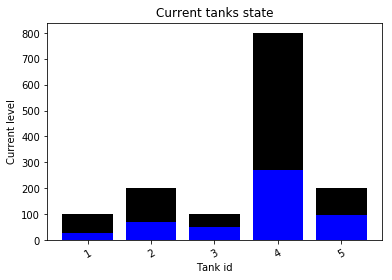

In [14]:
test_Q()
#print(np.mean(test_rewards_list) )

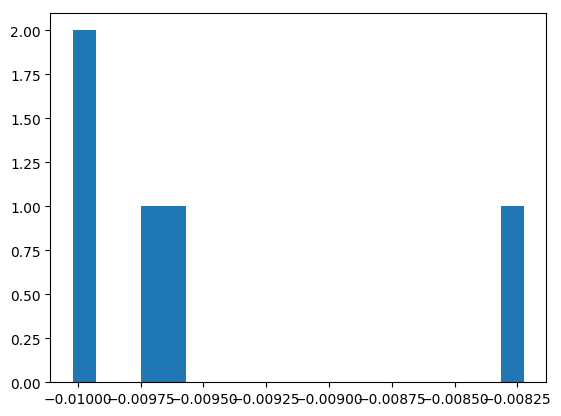

In [15]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [16]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


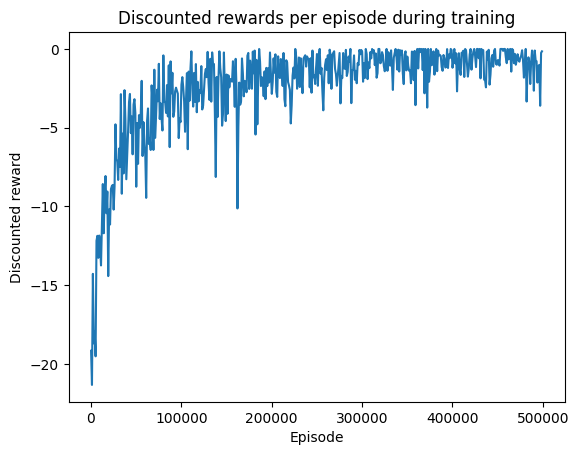

In [21]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [13]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [20]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose =True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )

    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -498.4153942 -498.4153942 0.0 5500
Episode 1 t 2 -858.0806194 -294.7068994 563.37372 4500
Episode 1 t 3 -550.7873265 -435.2234865 115.56384 0500
Episode 1 t 4 -1598.6972709 32.6101491 1631.30742 2400
Episode 1 t 5 27.1089953 27.1089953 0.0 5500
Episode 1 t 6 -714.3068852 -150.9331652 563.37372 4500
Episode 1 t 7 -728.1614356 -728.1614356 0.0 5500
Episode 1 t 8 -1141.8074708 20.0218492 1161.82932 0300
Episode 1 t 9 -1590.7931437 18.8460563 1609.6392 4300
Episode 1 t 10 -31.701408 -31.701408 0.0 5500
Episode 1 t 11 -2742.9400156 -1111.6325956 1631.30742 2300
Episode 1 t 12 -1415.311724 -253.482404 1161.82932 0400
Episode 1 t 13 -1593.4009394 27.0723706 1620.47331 1300
Episode 1 t 14 -1589.7945588 19.8446412 1609.6392 3300
Episode 1 t 15 -1014.2718916 -450.8981716 563.37372 4500
Episode 1 t 16 -1138.4692297 23.3600903 1161.82932 0300
Episode 1 t 17 -1195.0814822 -610.0395422 585.04194 2500
Episode 1 t 18 -159

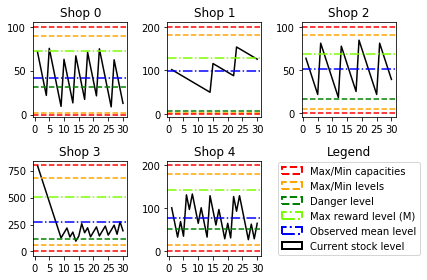

Total discounted rewards Level rewards Transport rewards
-10019.5184611556 -9891.103652044501 27717.780660000004
Average trucks sent:  40.0
Average 1st type Trucks sent to each shop: [7. 2. 4. 2. 8. 7.]
Average 1st type Trucks sent: 23.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0. 14.  3. 13.]
Average 2nd type Trucks sent: 17.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  0.  0. 30.  0.]
Average level counts for shop 3: [ 0.  0.  1. 27.  2.]
Average level counts for shop 4: [ 0.  0.  7. 23.  0.]
Average total level counts: [  0.   0.  19. 129.   2.]
Percentage total level counts: [ 0.          0.         12.66666667 86.          1.33333333]


In [21]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)


Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5
Test episode: 6
Test episode: 7
Test episode: 8
Test episode: 9
Test episode: 10
Test episode: 11
Test episode: 12
Test episode: 13
Test episode: 14
Test episode: 15
Test episode: 16
Test episode: 17
Some tank is in a forbidden level
Test episode: 18
Test episode: 19
Test episode: 20
Test episode: 21
Test episode: 22
Test episode: 23
Test episode: 24
Test episode: 25
Test episode: 26
Test episode: 27
Test episode: 28
Test episode: 29
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some t

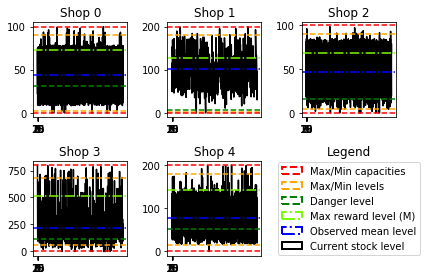

Total discounted rewards Level rewards Transport rewards
-156145.84893092385 -804347.0526326387 29285.419626900006
Average trucks sent:  42.47
Average 1st type Trucks sent to each shop: [6.75 0.84 4.3  4.55 8.74 4.82]
Average 1st type Trucks sent: 25.18
Average 2nd type Trucks sent to each shop: [ 0.09  0.25  0.   14.23  2.72 12.71]
Average 2nd type Trucks sent: 17.29
Average number of trucks not deliverying: 0.09
Average level counts for shop 0: [4.000e-02 2.000e-02 9.340e+00 2.041e+01 1.900e-01]
Average level counts for shop 1: [1.100e-01 2.000e-02 2.000e-02 2.955e+01 3.000e-01]
Average level counts for shop 2: [ 0.5   0.16  1.34 27.89  0.11]
Average level counts for shop 3: [ 0.1   0.5   1.37 27.69  0.34]
Average level counts for shop 4: [1.000e-02 0.000e+00 7.110e+00 2.276e+01 1.200e-01]
Average total level counts: [  0.76   0.7   19.18 128.3    1.06]
Percentage total level counts: [ 0.50666667  0.46666667 12.78666667 85.53333333  0.70666667]


In [18]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)
